In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, Ridge

In [2]:
import eda
import regression as reg
%reload_ext autoreload
%autoreload 2

In [3]:
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 60)
pd.set_option('max_colwidth', 20)

In [4]:
#Get the latest listings.csv.gz from http://insideairbnb.com/get-the-data.html
#Then convert it to pandas dataframe

df_london = pd.read_csv("listings 2.csv")
#df_london = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2019-09-14/data/listings.csv.gz")

In [5]:
df_london.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airb...,20190914144451,2019-09-15,Arty and Bright ...,Unlike most rent...,Amenities Beddin...,Unlike most rent...,family,Not even 10 minu...,No Smoking (very...,Tons of buses (2...,Guest will have ...,No interaction w...,No Smoking (very...,NaN,NaN,https://a0.musca...,NaN,43039,https://www.airb...,Adriano,2009-10-03,"London, England,...","Hello, I'm a fri...",within an hour,100%,NaN,t,https://a0.musca...,https://a0.musca...,Brixton,3.0,3.0,"['email', 'phone...",t,t,"London, United K...",Brixton,Lambeth,NaN,London,NaN,SW9 8DG,London,"London, United K...",GB,United Kingdom,51.46225,-0.11732,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",I...",NaN,$88.00,$645.00,"$2,350.00",$400.00,$30.00,2,$20.00,2,180,2,2,180,180,2.0,180.0,4 days ago,t,19,42,72,344,2019-09-15,184,1,2010-03-21,2019-07-10,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,f,strict_14_with_g...,f,t,2,2,0,0,1.59
1,13913,https://www.airb...,20190914144451,2019-09-15,Holiday London D...,My bright double...,"Hello Everyone, ...",My bright double...,business,Finsbury Park is...,For art lovers I...,The flat only a ...,Guest will have ...,I like to have l...,I'm an artist an...,NaN,NaN,https://a0.musca...,NaN,54730,https://www.airb...,Alina,2009-11-16,"London, England,...",I am a Multi-Med...,within an hour,100%,NaN,f,https://a0.musca...,https://a0.musca...,LB of Islington,4.0,4.0,"['email', 'phone...",t,f,"Islington, Great...",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, Unite...",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",W...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,5 months ago,t,18,48,78,353,2019-09-15,16,2,2010-08-18,2019-06-10,96.0,9.0,10.0,9.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,3,1,2,0,0.14
2,15400,https://www.airb...,20190914144451,2019-09-15,Bright Chelsea ...,Lots of windows ...,Bright Chelsea A...,Lots of windows ...,romantic,It is Chelsea.,The building nex...,The underground ...,There are two wa...,If I am in the c...,NO SMOKING PLEAS...,NaN,NaN,https://a0.musca...,NaN,60302,https://www.airb...,Philippa,2009-12-05,"Kensington, Engl...","English, grandmo...",within a few hours,100%,NaN,

In [6]:
#Run a profiling report for initial EDA

# london_report = df_london.profile_report(title="London Airbnb Listing Detailed Profiling Report")
# london_report.to_file(output_file="londondetailed.html")

In [7]:
columns_for_deletion = ["listing_url", "scrape_id", "name", "summary", "space", "description", "neighborhood_overview", "notes", "transit", "access", "interaction", "house_rules", 
           "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_id", "host_url", "host_name", "host_location", "host_about", "host_response_time", 
           "host_response_rate", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_listings_count", 
           "host_total_listings_count", "street", "neighbourhood_group_cleansed", "city", "state", "zipcode", "market", "smart_location", "country_code", "country", 
           "square_feet", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", 
           "maximum_nights_avg_ntm", "calendar_updated", "has_availability", "calendar_last_scraped", "license", "jurisdiction_names", "is_business_travel_ready"]

df_delete = df_london[columns_for_deletion]
df_delete.head()

,listing_url,scrape_id,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,street,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,square_feet,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,calendar_last_scraped,license,jurisdiction_names,is_business_travel_ready
0,https://www.airb...,20190914144451,Arty and Bright ...,Unlike most rent...,Amenities Beddin...,Unlike most rent...,Not even 10 minu...,No Smoking (very...,Tons of buses (2...,Guest will have ...,No interaction w...,No Smoking (very...,NaN,NaN,https://a0.musca...,NaN,43039,https://www.airb...,Adriano,"London, England,...","Hello, I'm a fri...",within an hour,100%,NaN,https://a0.musca...,https://a0.musca...,Brixton,3.0,3.0,"London, United K...",NaN,London,NaN,SW9 8DG,London,"London, United K...",GB,United Kingdom,NaN,2,2,180,180,2.0,180.0,4 days ago,t,2019-09-15,NaN,NaN,f
1,https://www.airb...,20190914144451,Holiday London D...,My bright double...,"Hello Everyone, ...",My bright double...,Finsbury Park is...,For art lovers I...,The flat only a ...,Guest will have ...,I like to have l...,I'm an artist an...,NaN,NaN,https://a0.musca...,NaN,54730,https://www.airb...,Alina,"London, England,...",I am a Multi-Med...,within an hour,100%,NaN,https://a0.musca...,https://a0.musca...,LB of Islington,4.0,4.0,"Islington, Great...",NaN,Islington,Greater London,N4 3,London,"Islington, Unite...",GB,United Kingdom,538.0,1,1,29,29,1.0,29.0,5 months ago,t,2019-09-15,NaN,NaN,f
2,https://www.airb...,20190914144451,Bright Chelsea ...,Lots of windows ...,Bright Chelsea A...,Lots of windows ...,It is Chelsea.,The building nex...,The underground ...,There are two wa...,If I am in the c...,NO SMOKING PLEAS...,NaN,NaN,https://a0.musca...,NaN,60302,https://www.airb...,Philippa,"Kensington, Engl...","English, grandmo...",within a few hours,100%,NaN,https://a0.musca...,https://a0.musca...,Chelsea,1.0,1.0,"London, United K...",NaN,London,NaN,SW3,London,"London, United K...",GB,United Kingdom,NaN,30,30,50,50,30.0,50.0,4 days ago,t,2019-09-15,NaN,NaN,f
3,https://www.airb...,20190914144451,Superb 3-Bed/2 B...,You'll have a wo...,This is a wonder...,You'll have a wo...,"Location, locati...",This property ha...,You can walk to ...,Full use of whol...,Always available...,The apartment be...,NaN,NaN,https://a0.musca...,NaN,67564,https://www.airb...,Liz,"London, England,...",We are Liz and J...,within an hour,98%,NaN,https://a0.musca...,https://a0.musca...,Fitzrovia,18.0,18.0,"London, Fitzrovi...",NaN,London,Fitzrovia,W1T4BP,London,"London, United K...",GB,United Kingdom,NaN,2,3,365,365,3.0,365.0,5 days ago,t,2019-09-15,NaN,NaN,f
4,https://www.airb...,20190914144451,Battersea bedroo...,"Artist house, br...",- End of terrace...,"Artist house, br...",- Battersea is a...,- Please have a ...,- 5 mins walk to...,- there is a com...,We rent out our ...,A house manual w...,NaN,NaN,https://a0.musca...,NaN,41759,https://www.airb...,Joe,"London, England,...",I've been using ...,within a day,80%,NaN,https://a0.musca...,https://a0.musca...,Battersea,0.0,0.0,"London, United K...",NaN,London,NaN,SW11 5GX,London,"London, United K...",GB,United Kingdom,1001.0,30,30,1125,1125,30.0,1125.0,6 months ago,t,2019-09-15,NaN,NaN,f


In [8]:
# delete = df_delete.profile_report(title="Columns For Deletion - Profiling Report")
# delete.to_file(output_file="delete.html")

In [9]:
#Delete highly correlated or similar columns and those with only null values based on the Profiling Report 
#Delete columns which will not be used modeling

df_londonairbnb = df_london.drop(columns_for_deletion, axis = 1)
df_londonairbnb.dropna(subset = ["id"], axis = 0, inplace = True) #all disctint listings except for one null value
df_londonairbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85273 entries, 0 to 85272
Data columns (total 55 columns):
id                                              85273 non-null int64
last_scraped                                    85273 non-null object
experiences_offered                             85273 non-null object
host_since                                      85257 non-null object
host_is_superhost                               85257 non-null object
host_verifications                              85273 non-null object
host_has_profile_pic                            85257 non-null object
host_identity_verified                          85257 non-null object
neighbourhood                                   85273 non-null object
neighbourhood_cleansed                          85273 non-null object
latitude                                        85273 non-null float64
longitude                                       85273 non-null float64
is_location_exact                               85

In [10]:
#Run another profiling report after deleting columns

# london_report2 = df_londonairbnb.profile_report(title="London Airbnb Listing Detailed Profiling Report (2)")
# london_report2.to_file(output_file="londondetailed2.html")

In [11]:
# london_report2

In [12]:
#Check the zero and null values of continuous features

df_londonairbnb.select_dtypes("float64").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85273 entries, 0 to 85272
Data columns (total 13 columns):
latitude                       85273 non-null float64
longitude                      85273 non-null float64
bathrooms                      85146 non-null float64
bedrooms                       85231 non-null float64
beds                           85120 non-null float64
review_scores_rating           62591 non-null float64
review_scores_accuracy         62540 non-null float64
review_scores_cleanliness      62553 non-null float64
review_scores_checkin          62492 non-null float64
review_scores_communication    62547 non-null float64
review_scores_location         62493 non-null float64
review_scores_value            62492 non-null float64
reviews_per_month              64270 non-null float64
dtypes: float64(13)
memory usage: 9.1 MB


In [13]:
#Delete rows where column has only one nan value

nan_to_delete = ["latitude", "longitude","accommodates", "guests_included", "minimum_nights", "maximum_nights", "availability_365", "calculated_host_listings_count"]
df_londonairbnb.dropna(subset = nan_to_delete, axis = 0, inplace = True)

In [14]:
#Check which proxy to be used for zero and null values

# for col in list(df_londonairbnb.select_dtypes("float64").columns):
#     eda.check_zero_nan(df_londonairbnb[col], replace = "mode")

In [15]:
#bathrooms proxy 1 (mode) for null and zeroes
df_londonairbnb.bathrooms = eda.replace_zero_nan(df_londonairbnb.bathrooms, 1)

#bedrooms proxy 0 for null and zeroes, assume studio type for bedrooms = 0
df_londonairbnb.bedrooms = eda.replace_zero_nan(df_londonairbnb.bedrooms, 0)

#bed proxy 1 (mode) for null and zeroes
df_londonairbnb.beds = eda.replace_zero_nan(df_londonairbnb.beds, 1)

#review scores and count proxy 0 for null
df_londonairbnb.review_scores_rating = eda.replace_zero_nan(df_londonairbnb.review_scores_rating, replace = 0)
df_londonairbnb.review_scores_accuracy = eda.replace_zero_nan(df_londonairbnb.review_scores_accuracy, replace = 0)
df_londonairbnb.review_scores_cleanliness = eda.replace_zero_nan(df_londonairbnb.review_scores_cleanliness, replace = 0)
df_londonairbnb.review_scores_communication = eda.replace_zero_nan(df_londonairbnb.review_scores_communication, replace = 0)
df_londonairbnb.review_scores_checkin = eda.replace_zero_nan(df_londonairbnb.review_scores_checkin, replace = 0)
df_londonairbnb.review_scores_location = eda.replace_zero_nan(df_londonairbnb.review_scores_location, replace = 0)
df_londonairbnb.review_scores_value = eda.replace_zero_nan(df_londonairbnb.review_scores_value, replace = 0)
df_londonairbnb.reviews_per_month = eda.replace_zero_nan(df_londonairbnb.reviews_per_month, replace = 0)

#reviews_per_month proxy 0 for null values
df_londonairbnb.reviews_per_month = eda.replace_zero_nan(df_londonairbnb.reviews_per_month, 0)

#Check if all float columns have been dealt with
df_londonairbnb.select_dtypes("float64").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85273 entries, 0 to 85272
Data columns (total 13 columns):
latitude                       85273 non-null float64
longitude                      85273 non-null float64
bathrooms                      85273 non-null float64
bedrooms                       85273 non-null float64
beds                           85273 non-null float64
review_scores_rating           85273 non-null float64
review_scores_accuracy         85273 non-null float64
review_scores_cleanliness      85273 non-null float64
review_scores_checkin          85273 non-null float64
review_scores_communication    85273 non-null float64
review_scores_location         85273 non-null float64
review_scores_value            85273 non-null float64
reviews_per_month              85273 non-null float64
dtypes: float64(13)
memory usage: 9.1 MB


In [16]:
#Next, check null and zero values of categorical columns

df_londonairbnb.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85273 entries, 0 to 85272
Data columns (total 27 columns):
last_scraped                        85273 non-null object
experiences_offered                 85273 non-null object
host_since                          85257 non-null object
host_is_superhost                   85257 non-null object
host_verifications                  85273 non-null object
host_has_profile_pic                85257 non-null object
host_identity_verified              85257 non-null object
neighbourhood                       85273 non-null object
neighbourhood_cleansed              85273 non-null object
is_location_exact                   85273 non-null object
property_type                       85273 non-null object
room_type                           85273 non-null object
bed_type                            85273 non-null object
amenities                           85273 non-null object
price                               85273 non-null object
weekly_price         

In [17]:
#Delete rows where column has <50 nan values

nan_to_delete = ["host_since", "host_is_superhost", "host_has_profile_pic", "host_identity_verified"]
df_londonairbnb.dropna(subset = nan_to_delete, axis = 0, inplace = True)
df_londonairbnb.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85257 entries, 0 to 85272
Data columns (total 27 columns):
last_scraped                        85257 non-null object
experiences_offered                 85257 non-null object
host_since                          85257 non-null object
host_is_superhost                   85257 non-null object
host_verifications                  85257 non-null object
host_has_profile_pic                85257 non-null object
host_identity_verified              85257 non-null object
neighbourhood                       85257 non-null object
neighbourhood_cleansed              85257 non-null object
is_location_exact                   85257 non-null object
property_type                       85257 non-null object
room_type                           85257 non-null object
bed_type                            85257 non-null object
amenities                           85257 non-null object
price                               85257 non-null object
weekly_price         

In [18]:
#Check which proxy to be used for zero and null values

# for col in list(df_londonairbnb.select_dtypes("object").columns):
#     eda.check_zero_nan_object(df_londonairbnb[col])

In [19]:
#weekly_price proxy 0 for null values
df_londonairbnb.weekly_price = eda.replace_zero_nan(df_londonairbnb.weekly_price, "$0.00")

#monthly_price proxy 0 for null values
df_londonairbnb.monthly_price = eda.replace_zero_nan(df_londonairbnb.monthly_price, "$0.00")

#security_deposit proxy 0 for null values
df_londonairbnb.security_deposit = eda.replace_zero_nan(df_londonairbnb.security_deposit, "$0.00")

#cleaning_fee proxy 0 for null values
df_londonairbnb.cleaning_fee = eda.replace_zero_nan(df_londonairbnb.cleaning_fee, "$0.00")

df_londonairbnb.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85257 entries, 0 to 85272
Data columns (total 27 columns):
last_scraped                        85257 non-null object
experiences_offered                 85257 non-null object
host_since                          85257 non-null object
host_is_superhost                   85257 non-null object
host_verifications                  85257 non-null object
host_has_profile_pic                85257 non-null object
host_identity_verified              85257 non-null object
neighbourhood                       85257 non-null object
neighbourhood_cleansed              85257 non-null object
is_location_exact                   85257 non-null object
property_type                       85257 non-null object
room_type                           85257 non-null object
bed_type                            85257 non-null object
amenities                           85257 non-null object
price                               85257 non-null object
weekly_price         

In [20]:
#Update categorical columns with values 't' and 'f', then change dtype to 'int64'

t_or_f = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", "require_guest_phone_verification",
         "require_guest_profile_picture", "instant_bookable", "requires_license"]

eda.binary_col(df_londonairbnb, t_or_f)
df_londonairbnb[t_or_f].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,require_guest_phone_verification,require_guest_profile_picture,instant_bookable,requires_license
0,1,1,1,1,1,0,1,0
1,0,1,0,1,0,0,0,0
2,1,1,1,1,1,1,1,0
3,1,1,1,1,0,0,1,0
4,0,1,1,1,1,1,0,0


In [21]:
#Convert money columns to 'float64'

money_columns = ["price", "weekly_price", "monthly_price", "security_deposit", "cleaning_fee", "extra_people"]
eda.update_money_columns(df_londonairbnb, money_columns)
df_londonairbnb.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85257 entries, 0 to 85272
Data columns (total 13 columns):
last_scraped              85257 non-null object
experiences_offered       85257 non-null object
host_since                85257 non-null object
host_verifications        85257 non-null object
neighbourhood             85257 non-null object
neighbourhood_cleansed    85257 non-null object
property_type             85257 non-null object
room_type                 85257 non-null object
bed_type                  85257 non-null object
amenities                 85257 non-null object
first_review              64263 non-null object
last_review               64263 non-null object
cancellation_policy       85257 non-null object
dtypes: object(13)
memory usage: 9.1+ MB


In [22]:
#Convert 'host_since' and 'last_review' to number of days

df_londonairbnb['host_days'] = pd.to_datetime(df_londonairbnb['last_scraped']) - pd.to_datetime(df_londonairbnb['host_since'])
df_londonairbnb["days_from_last_review"] = pd.to_datetime(df_londonairbnb['last_scraped']) - pd.to_datetime(df_london['last_review'])
df_londonairbnb['host_days'] = df_londonairbnb['host_days']/ np.timedelta64(1, 'D')
df_londonairbnb["days_from_last_review"] = df_londonairbnb["days_from_last_review"] / np.timedelta64(1, 'D')
df_londonairbnb["days_from_last_review"].fillna(value = 0, inplace = True)

In [23]:
df_londonairbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85257 entries, 0 to 85272
Data columns (total 57 columns):
id                                              85257 non-null int64
last_scraped                                    85257 non-null object
experiences_offered                             85257 non-null object
host_since                                      85257 non-null object
host_is_superhost                               85257 non-null int64
host_verifications                              85257 non-null object
host_has_profile_pic                            85257 non-null int64
host_identity_verified                          85257 non-null int64
neighbourhood                                   85257 non-null object
neighbourhood_cleansed                          85257 non-null object
latitude                                        85257 non-null float64
longitude                                       85257 non-null float64
is_location_exact                               85257

In [24]:
#Transform amenities to count of amenities

df_londonairbnb['amenities_count'] = df_londonairbnb.amenities.map(lambda x: len(x.replace('{', '').replace('}', ',').replace('"', '').split(',')))
df_londonairbnb.head()

,id,last_scraped,experiences_offered,host_since,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days,days_from_last_review,amenities_count
0,11551,2019-09-15,family,2009-10-03,1,"['email', 'phone...",1,1,Brixton,Lambeth,51.46225,-0.11732,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",I...",88.0,645.0,2350.0,400.0,30.0,2,20.0,2,180,19,42,72,344,184,1,2010-03-21,2019-07-10,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,1,strict_14_with_g...,0,1,2,2,0,0,1.59,3634.0,67.0,23
1,13913,2019-09-15,business,2009-11-16,0,"['email', 'phone...",1,0,LB of Islington,Islington,51.56802,-0.11121,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",W...",65.0,333.0,1176.0,100.0,15.0,1,15.0,1,29,18,48,78,353,16,2,2010-08-18,2019-06-10,96.0,9.0,10.0,9.0,10.0,9.0,9.0,0,0,moderate,0,0,3,1,2,0,0.14,3590.0,97.0,55
2,15400,2019-09-15,romantic,2009-12-05,1,"['email', 'phone...",1,1,Chelsea,Kensington and C...,51.48796,-0.16898,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",I...",100.0,600.0,2250.0,150.0,50.0,2,0.0,30,50,8,8,8,114,87,6,2009-12-21,2019-08-27,96.0,10.0,10.0,10.0,10.0,10.0,9.0,0,1,strict_14_with_g...,1,1,1,1,0,0,0.73,3571.0,19.0,29
3,17402,2019-09-15,none,2010-01-04,1,"['email', 'phone...",1,1,City of Westminster,Westminster,51.52098,-0.14002,1,Apartment,Entire home/apt,6,2.0,3.0,4.0,Real Bed,"{TV,Wifi,Kitchen...",300.0,1378.0,0.0,350.0,65.0,4,10.0,3,365,12,36,54,265,41,5,2011-03-21,2019-06-19,94.0,10.0,9.0,9.0,9.0,10.0,9.0,0,1,strict_14_with_g...,0,0,15,15,0,0,0.40,3541.0,88.0,31
4,24328,2019-09-15,family,2009-09-28,0,"['email', 'phone...",1,1,LB of Wandsworth,Wandsworth,51.47298,-0.16376,1,Townhouse,Entire home/apt,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",I...",175.0,1050.0,3500.0,250.0,70.0,2,0.0,30,1125,11,41,71,346,93,1,2010-11-15,2019-06-08,98.0,10.0,10.0,10.0,10.0,9.0,9.0,0,0,moderate,1,1,1,1,0,0,0.86,3639.0,99.0,27


In [25]:
df_londonairbnb.to_csv("londonairbnb_cleaned.csv", index = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


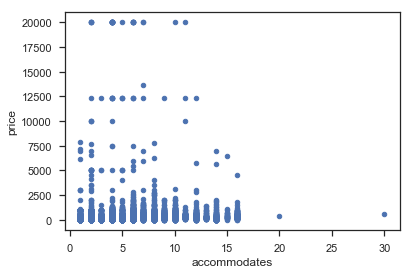

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


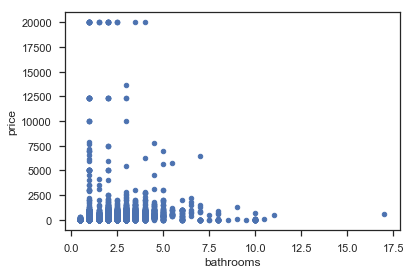

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


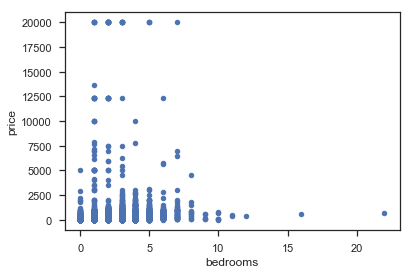

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


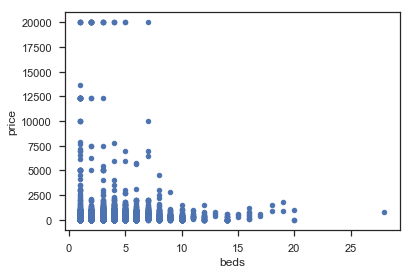

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


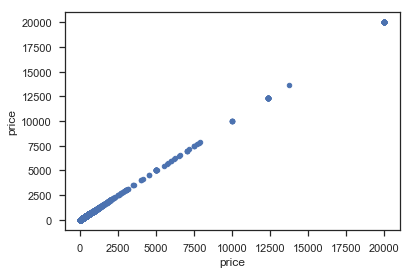

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


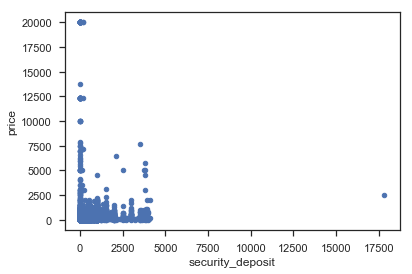

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


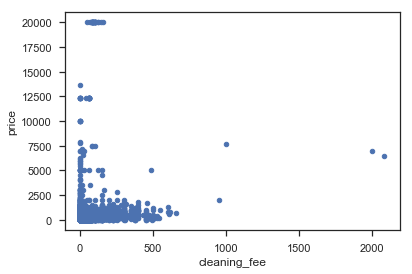

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


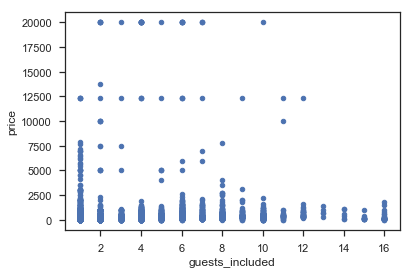

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


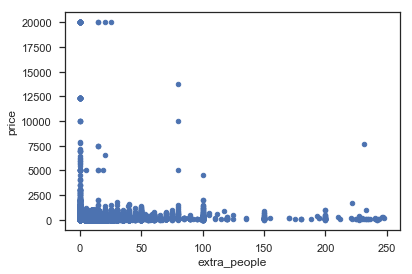

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


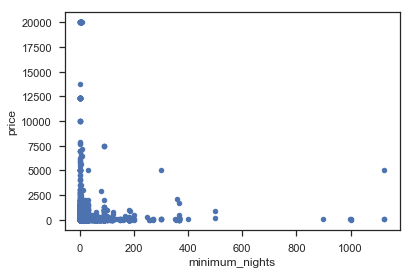

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


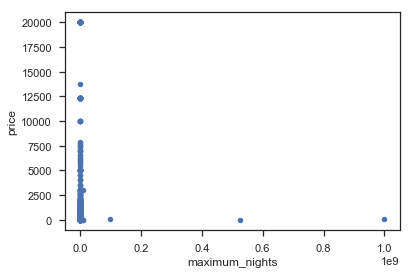

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


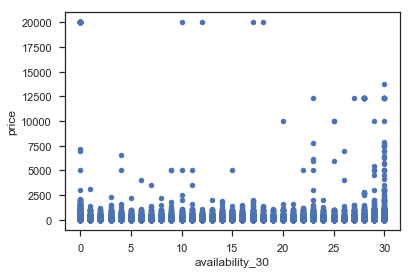

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


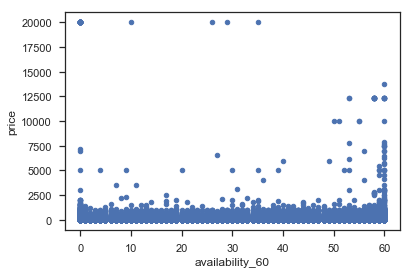

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


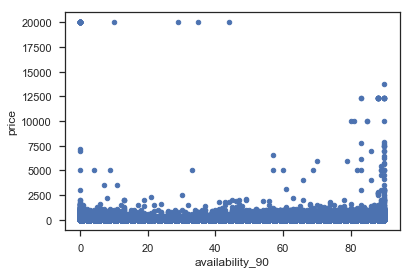

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


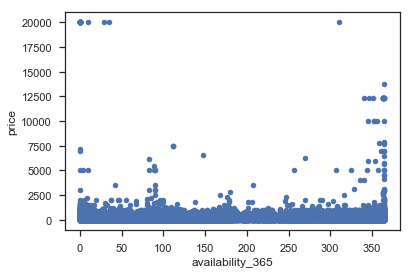

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


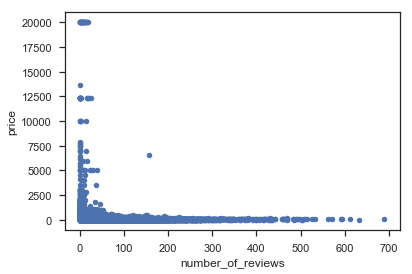

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


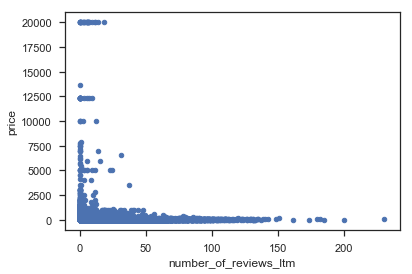

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


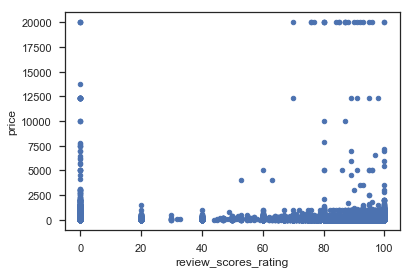

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


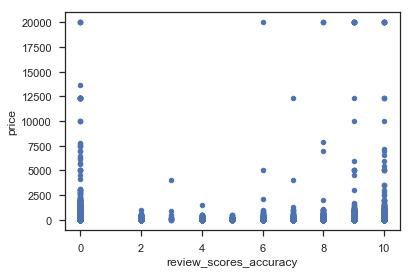

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


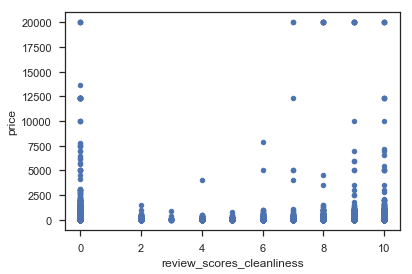

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


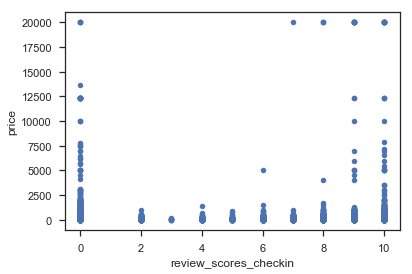

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


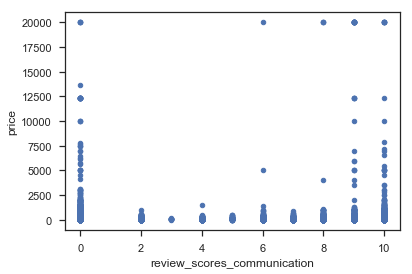

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


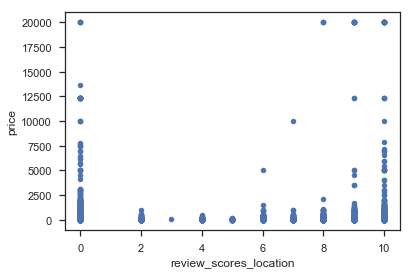

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


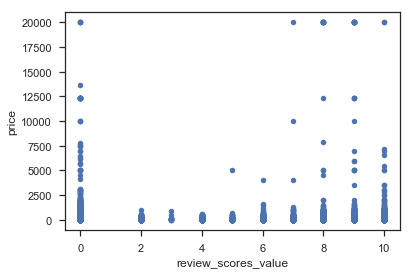

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


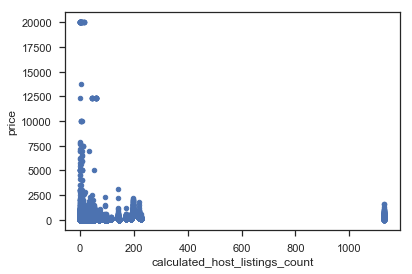

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


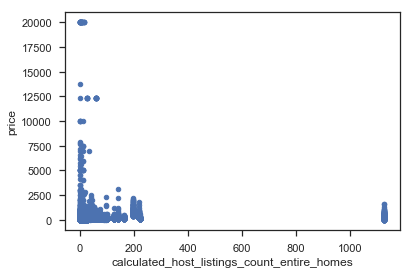

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


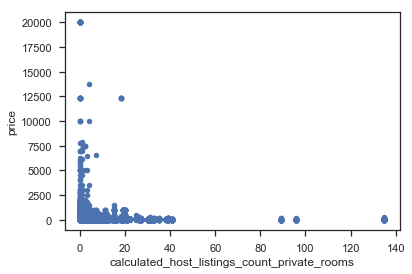

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


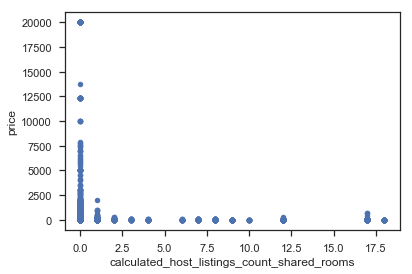

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


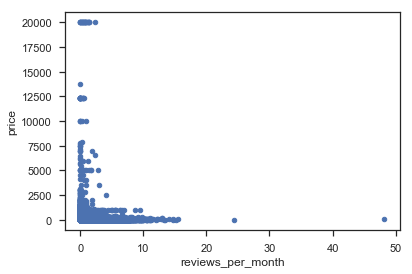

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


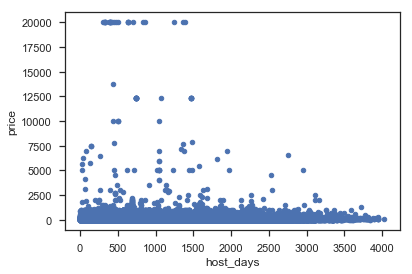

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


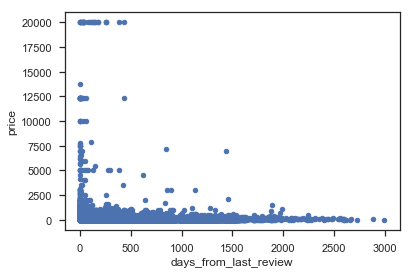

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


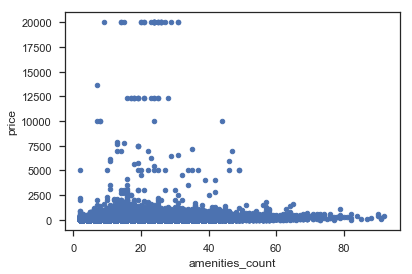

In [26]:
#Remove outliers
df_londonairbnb_cf = df_londonairbnb.select_dtypes(["int64","float64"]).drop(["id","host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", "require_guest_phone_verification",
         "require_guest_profile_picture", "instant_bookable", "requires_license", "latitude", "longitude","weekly_price", "monthly_price"], axis = 1)

for col in list(df_londonairbnb_cf.columns):
    df_londonairbnb_cf.plot.scatter(x = col , y = "price")
    plt.show();

In [27]:
# columns = list(df_londonairbnb_cf_cleaned.columns)
# columns.remove("price")

# fig = plt.figure(figsize= (50,200))

# for i, col in enumerate(columns):
#     sns.distplot(df_londonairbnb_cf_cleaned[col], ax=ax1)
#     sns.distplot(df_londonairbnb_cf[col], ax=ax2);
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf_cleaned, ax=ax3)
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf, ax=ax4, alpha = 0.5)
#     ax1 = fig.add_subplot(31, 4, i+1)
#     ax2 = fig.add_subplot(31, 4, i+2)
#     ax3 = fig.add_subplot(31, 4, i+3)
#     ax4 = fig.add_subplot(31, 4, i+4)
#     sns.distplot(df_londonairbnb_cf_cleaned[col], ax=ax1)
#     sns.distplot(df_londonairbnb_cf[col], ax=ax2);
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf_cleaned, ax=ax3)
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf, ax=ax4, alpha = 0.5)
    

# plt.show()

In [28]:
df_londonairbnb_cf_cleaned = df_londonairbnb_cf[(np.abs(stats.zscore(df_londonairbnb_cf)) < 3).all(axis = 1)]
df_londonairbnb_cf_cleaned.head()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days,days_from_last_review,amenities_count
2,2,1.0,1.0,1.0,100.0,150.0,50.0,2,0.0,30,50,8,8,8,114,87,6,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1,1,0,0,0.73,3571.0,19.0,29
3,6,2.0,3.0,4.0,300.0,350.0,65.0,4,10.0,3,365,12,36,54,265,41,5,94.0,10.0,9.0,9.0,9.0,10.0,9.0,15,15,0,0,0.40,3541.0,88.0,31
4,2,1.5,1.0,1.0,175.0,250.0,70.0,2,0.0,30,1125,11,41,71,346,93,1,98.0,10.0,10.0,10.0,10.0,9.0,9.0,1,1,0,0,0.86,3639.0,99.0,27
6,2,1.5,1.0,1.0,29.0,100.0,0.0,1,8.0,10,1120,12,12,26,288,122,5,95.0,10.0,10.0,10.0,10.0,9.0,10.0,3,0,3,0,1.06,3450.0,79.0,17
7,4,1.0,1.0,3.0,147.0,100.0,75.0,3,15.0,3,365,13,34,64,339,63,9,85.0,8.0,9.0,9.0,9.0,9.0,8.0,3,3,0,0,0.58,3436.0,55.0,36


In [29]:
columns = list(df_londonairbnb_cf_cleaned.columns)
columns.remove("price")

# fig = plt.figure(figsize= (50,200))

# for i, col in enumerate(columns):
#     sns.distplot(df_londonairbnb_cf_cleaned[col])
#     sns.distplot(df_londonairbnb_cf[col])
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf_cleaned)
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf)
#     ax1 = fig.add_subplot(31, 4, i+1)
#     ax2 = fig.add_subplot(31, 4, i+2)
#     ax3 = fig.add_subplot(31, 4, i+3)
#     ax4 = fig.add_subplot(31, 4, i+4)
#     sns.distplot(df_londonairbnb_cf_cleaned[col], ax=ax1)
#     sns.distplot(df_londonairbnb_cf[col], ax=ax2)
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf_cleaned, ax=ax3)
#     sns.scatterplot(x=col, y="price", data=df_londonairbnb_cf, ax=ax4, alpha = 0.5)
    
# plt.show()

In [30]:
df_londonairbnb_final = pd.concat([df_londonairbnb_cf_cleaned, df_londonairbnb.drop(df_londonairbnb_cf_cleaned.columns, axis = 1)], axis = 1, join = "inner")
df_londonairbnb_final.head()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days,days_from_last_review,amenities_count,id,last_scraped,experiences_offered,host_since,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,bed_type,amenities,weekly_price,monthly_price,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
2,2,1.0,1.0,1.0,100.0,150.0,50.0,2,0.0,30,50,8,8,8,114,87,6,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1,1,0,0,0.73,3571.0,19.0,29,15400,2019-09-15,romantic,2009-12-05,1,"['email', 'phone...",1,1,Chelsea,Kensington and C...,51.48796,-0.16898,1,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",I...",600.0,2250.0,2009-12-21,2019-08-27,0,1,strict_14_with_g...,1,1
3,6,2.0,3.0,4.0,300.0,350.0,65.0,4,10.0,3,365,12,36,54,265,41,5,94.0,10.0,9.0,9.0,9.0,10.0,9.0,15,15,0,0,0.40,3541.0,88.0,31,17402,2019-09-15,none,2010-01-04,1,"['email', 'phone...",1,1,City of Westminster,Westminster,51.52098,-0.14002,1,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,Kitchen...",1378.0,0.0,2011-03-21,2019-06-19,0,1,strict_14_with_g...,0,0
4,2,1.5,1.0,1.0,175.0,250.0,70.0,2,0.0,30,1125,11,41,71,346,93,1,98.0,10.0,10.0,10.0,10.0,9.0,9.0,1,1,0,0,0.86,3639.0,99.0,27,24328,2019-09-15,family,2009-09-28,0,"['email', 'phone...",1,1,LB of Wandsworth,Wandsworth,51.47298,-0.16376,1,Townhouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",I...",1050.0,3500.0,2010-11-15,2019-06-08,0,0,moderate,1,1
6,2,1.5,1.0,1.0,29.0,100.0,0.0,1,8.0,10,1120,12,12,26,288,122,5,95.0,10.0,10.0,10.0,10.0,9.0,10.0,3,0,3,0,1.06,3450.0,79.0,17,25123,2019-09-15,none,2010-04-05,1,"['email', 'phone...",1,0,LB of Barnet,Barnet,51.57224,-0.20906,1,House,Private room,Real Bed,"{Wifi,Kitchen,""B...",195.0,795.0,2010-04-14,2019-06-28,0,1,strict_14_with_g...,0,0
7,4,1.0,1.0,3.0,147.0,100.0,75.0,3,15.0,3,365,13,34,64,339,63,9,85.0,8.0,9.0,9.0,9.0,9.0,8.0,3,3,0,0,0.58,3436.0,55.0,36,26223,2019-09-15,none,2010-04-19,0,"['email', 'phone...",1,1,LB of Islington,Islington,51.54168,-0.10207,1,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",I...",727.0,2747.0,2010-11-02,2019-07-22,0,1,strict_14_with_g...,0,0


In [31]:
df_londonairbnb_final.to_csv("londonairbnb_cleaned_outliers.csv", index = False)

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'calculated_host_listings_count', 'reviews_per_month', 'host_days',
       'days_from_last_review', 'amenities_count', 'experiences_offered',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'requires_license',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')


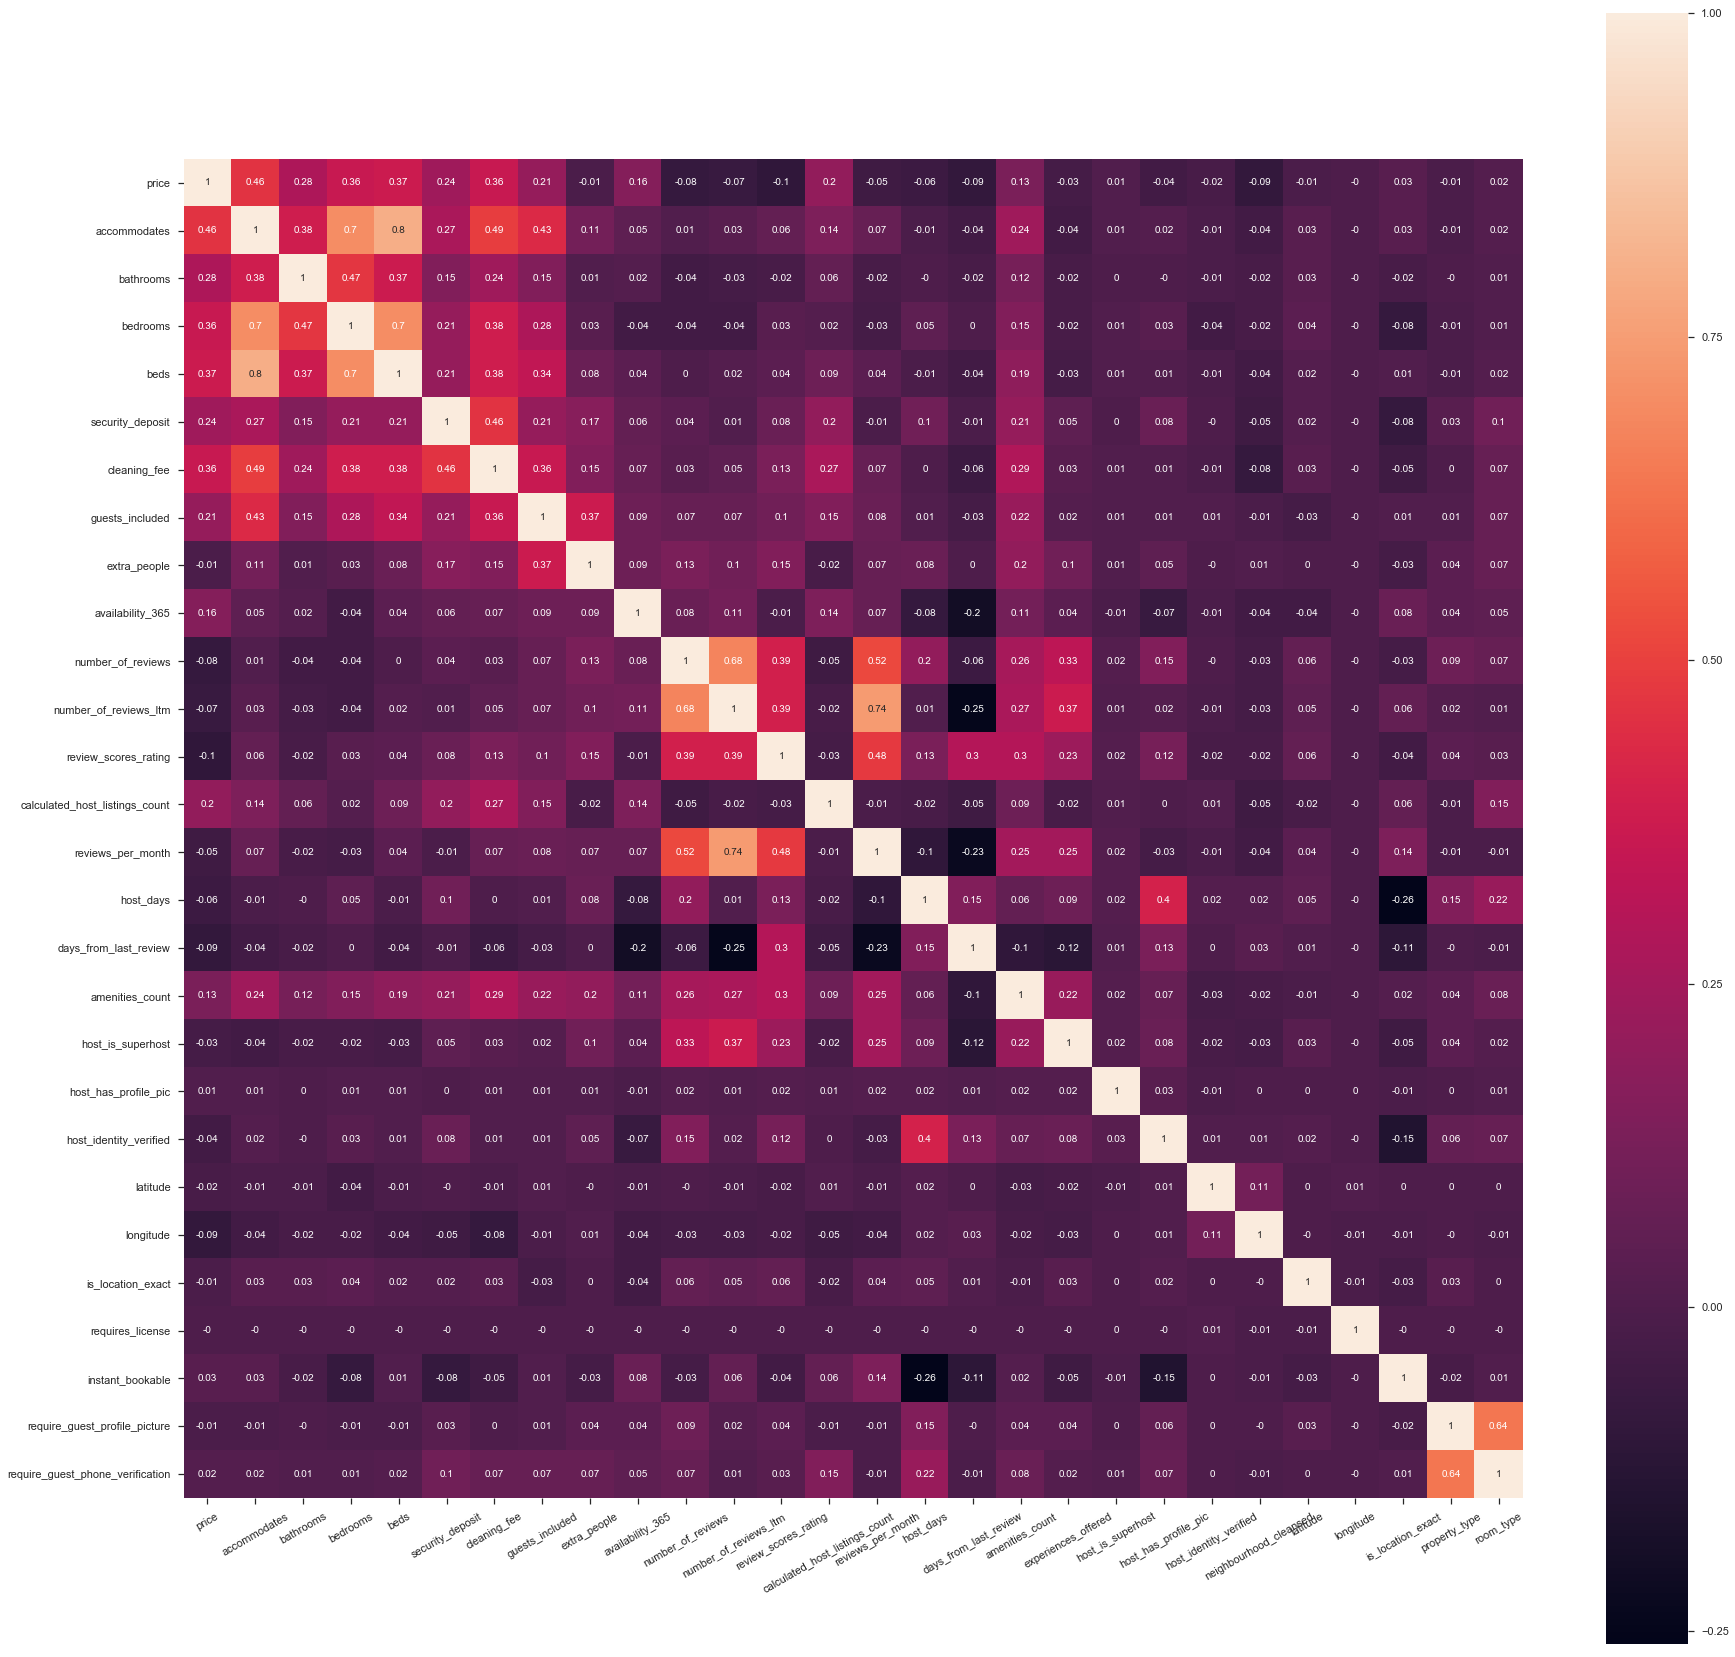

In [32]:
#Model no. 1

X_columns_exlude = ['id', 'last_scraped', 'host_since', 'amenities', 'host_verifications', 'neighbourhood', 'weekly_price',
                   'monthly_price', 'availability_30', 'availability_60', 'availability_90', 'first_review','last_review', 'price', 
                    'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin', 'calculated_host_listings_count_shared_rooms',
                    'review_scores_communication', 'review_scores_location','review_scores_value','minimum_nights', 'maximum_nights']

X = df_londonairbnb_final.drop(columns = X_columns_exlude, axis=1)
y = df_londonairbnb_final[["price"]]

model1 = pd.concat([y,X], axis = 1)

print(X.columns)

var_corr1 = round(model1.corr(), 2)
plt.figure(figsize=(30,30))
g = sns.heatmap(var_corr1, xticklabels=var_corr1.columns, yticklabels=var_corr1.columns, annot=True, square = "equal");
g.set_xticklabels(list(model1.columns), rotation = 30);


In [33]:
abs(model1.select_dtypes(["int64", "float64"]).corr())["price"].sort_values(ascending = False)

price                               1.000000
accommodates                        0.455245
beds                                0.371893
bedrooms                            0.364829
cleaning_fee                        0.364644
bathrooms                           0.279940
security_deposit                    0.242542
guests_included                     0.206337
calculated_host_listings_count      0.198103
availability_365                    0.160318
amenities_count                     0.125094
review_scores_rating                0.100600
days_from_last_review               0.094424
longitude                           0.086751
number_of_reviews                   0.081472
number_of_reviews_ltm               0.070135
host_days                           0.061816
reviews_per_month                   0.053709
host_identity_verified              0.036771
host_is_superhost                   0.033412
instant_bookable                    0.027119
require_guest_phone_verification    0.020624
latitude  

In [34]:
X_train, X_test, y_train, y_test = reg.preprocess(X, y)

In [35]:
#First Linear Regression Model

train_R2, test_R2, train_mse, test_mse, coefs, intercept = reg.run_linear(X_train, X_test, y_train, y_test)

print('Training r^2:', train_R2)
print('Testing r^2:', test_R2)
print('Training MSE:', train_mse)
print('Testing MSE:', test_mse)

Training r^2: 0.40548120691747025
Testing r^2: -40469352325781.25
Training MSE: 5544.6052044749085
Testing MSE: 3.996585779936339e+17


In [36]:
#First LASSO model

lasso_table = reg.run_lasso(X_train, X_test, y_train, y_test)
lasso_table.head()

,alpha,training_r^2,mse_train,testing_r^2,mse_test,intercept,coefficients
0,0.000000,0.405481,5544.605229,0.392413,6000.272912,[91.4136857482933],[13.803024235974...
1,0.201005,0.382486,5759.062805,0.383178,6091.476427,[110.06146076859...,[13.429595542338...
2,0.402010,0.372359,5853.511625,0.374731,6174.902427,[114.48904580662...,[13.088364585530...
3,0.603015,0.368780,5886.890526,0.370812,6213.600025,[113.89125668030...,[13.271340603546...
4,0.804020,0.365662,5915.965111,0.367555,6245.767748,[113.33334961352...,[13.529945543124...


In [37]:
best_lasso_coefficients = pd.DataFrame({"predictor": list(X_train.columns), "coef":lasso_table.coefficients.iloc[0]}).sort_values(by = "coef", ascending = False)
best_lasso_coefficients.head()

,predictor,coef
113,cancellation_pol...,922.622564
114,cancellation_pol...,467.522272
85,property_type_Ho...,242.584415
90,property_type_Is...,112.905632
70,property_type_Bo...,94.061215


In [38]:
best_lasso_coefficients["abs"] = abs(best_lasso_coefficients["coef"])
best_lasso_coefficients.query("abs > 0").head()

,predictor,coef,abs
113,cancellation_pol...,922.622564,922.622564
114,cancellation_pol...,467.522272,467.522272
85,property_type_Ho...,242.584415,242.584415
90,property_type_Is...,112.905632,112.905632
70,property_type_Bo...,94.061215,94.061215


In [39]:
#First Ridge model

ridge_table = reg.run_ridge(X_train, X_test, y_train, y_test)
ridge_table.head()

,alpha,training_r^2,mse_train,testing_r^2,mse_test,intercept,coefficients
1,0.201005,0.405455,5544.851401,3.929922e-01,5.994558e+03,[246.51562657208...,[[13.80078441448...
2,0.402010,0.405392,5545.432986,3.934118e-01,5.990414e+03,[237.35921900100...,[[13.79855108588...
3,0.603015,0.405310,5546.206337,3.937293e-01,5.987279e+03,[229.80219808342...,[[13.79635598791...
0,0.000000,0.405218,5547.059989,-6.464005e+22,6.383584e+26,[448712049449670.8],[[13.82355655059...
4,0.804020,0.405214,5547.092666,3.939767e-01,5.984835e+03,[223.3976263971616],[[13.79421353902...


In [40]:
best_ridge_coefficients = pd.DataFrame({"predictor": list(X_train.columns), "coef":ridge_table.coefficients.iloc[0].reshape(121,)}).sort_values(by = "coef", ascending = False)
best_ridge_coefficients

ValueError: cannot reshape array of size 120 into shape (121,)

In [ ]:
best_ridge_coefficients["abs"] = abs(best_ridge_coefficients["coef"])
best_ridge_coefficients.query("abs > 0")

In [ ]:
trainmodel1 = pd.concat([y_train,X_train], axis = 1)

abs(trainmodel1.corr())["price"].sort_values(ascending = False).head(10)

In [ ]:
X_columns_exlude = ['id', 'last_scraped', 'host_since', 'amenities', 'host_verifications', 'neighbourhood', 'weekly_price',
                   'monthly_price', 'availability_30', 'availability_60', 'availability_90', 'first_review','last_review', 'price', 
                    'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin', 'calculated_host_listings_count_shared_rooms',
                    'review_scores_communication', 'review_scores_location','review_scores_value','minimum_nights', 'maximum_nights']




num=['float64', 'int64']
london_numeric=df_londonairbnb_final.select_dtypes(num)

X = london_numeric.drop('price', axis=1)
y = london_numeric["price"]



model1 = pd.concat([y,X], axis = 1)
model1.shape

In [ ]:
#Polynomial Model no. 1

X_train, X_test, y_train, y_test = reg.preprocess(X, y)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

poly=PolynomialFeatures(degree=4)
poly_x_train=poly.fit_transform(X_train)

reg_poly=LinearRegression().fit(poly_x_train,y_train)
poly_x_test=poly.transform(X_test)

train_R2 = reg_poly.score(poly_x_train, y_train)
test_R2 = reg_poly.score(poly_x_test, y_test)
train_mse = mean_squared_error(y_train, reg_poly.predict(poly_x_train))
test_mse = mean_squared_error(y_test, reg_poly.predict(poly_x_test))
coefs = reg_poly.coef_
intercept = reg_poly.intercept_

print(train_R2, test_R2, train_mse, test_mse, coefs, intercept)
